Original resized image saved as 'serial_watermarked_image.tiff'.
Sequential PSNR embedding : 45.3058
Loop 1 Serial execution time: 231286ms
Original resized image saved as 'serial_watermarked_image.tiff'.
Sequential PSNR embedding : 45.3057
Loop 2 Serial execution time: 220660ms
Original resized image saved as 'serial_watermarked_image.tiff'.
Sequential PSNR embedding : 45.3048
Loop 3 Serial execution time: 223009ms

Serial Average execution time: 224985ms. 
New record has been appended to time_result.json

Omp PSNR embedding : 45.3058
Loop 1 OMP execution time: 28941ms
Omp PSNR embedding : 45.3057
Loop 2 OMP execution time: 33834ms
Omp PSNR embedding : 45.3048
Loop 3 OMP execution time: 32592ms

OMP Average execution time: 31789ms. 
New record has been appended to time_result.json

CUDA PSNR embedding : 45.3055
Loop 1 CUDA execution time: 4409ms
CUDA PSNR embedding : 45.3055
Loop 2 CUDA execution time: 3439ms
CUDA PSNR embedding : 45.3055
Loop 3 CUDA execution time: 3402ms

CUDA Avera

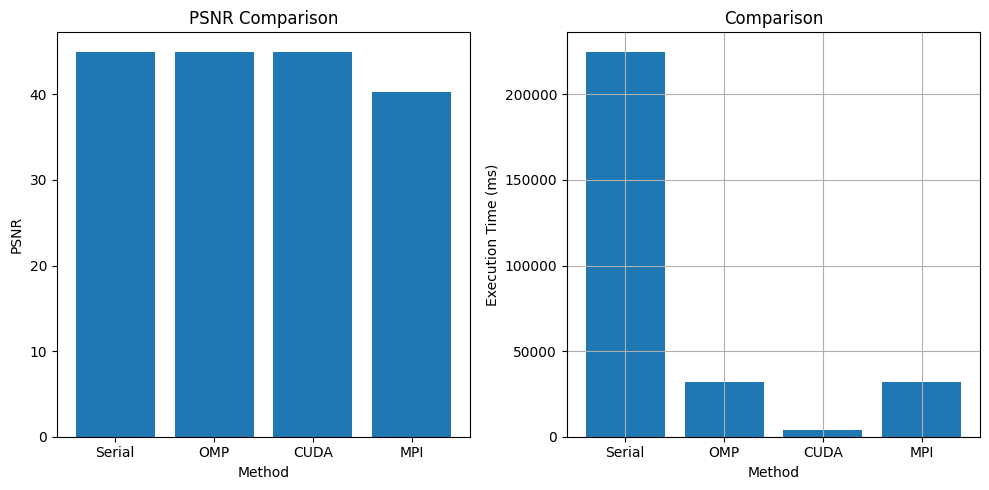

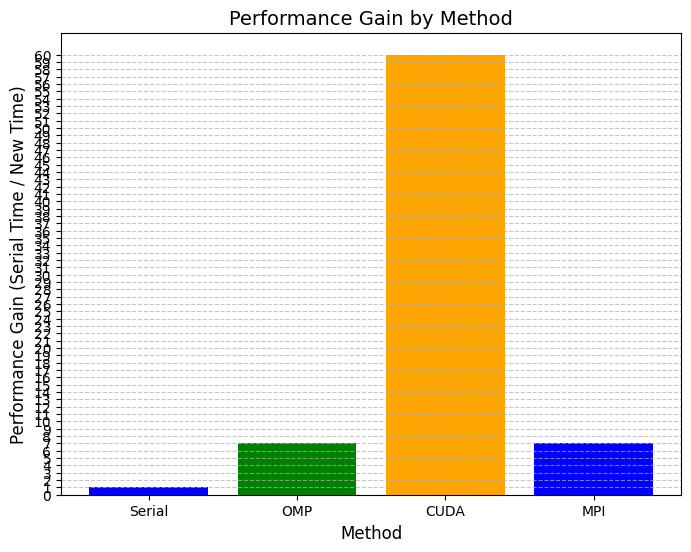

Original resized image saved as 'serial_watermarked_image.tiff'.
Sequential PSNR embedding : 45.9081
Loop 1 Serial execution time: 6918ms
Original resized image saved as 'serial_watermarked_image.tiff'.
Sequential PSNR embedding : 45.6806
Loop 2 Serial execution time: 10073ms
Original resized image saved as 'serial_watermarked_image.tiff'.
Sequential PSNR embedding : 46.2041
Loop 3 Serial execution time: 10401ms

Serial Average execution time: 9130.67ms. 
New record has been appended to time_result.json

Omp PSNR embedding : 45.9081
Loop 1 OMP execution time: 1037ms
Omp PSNR embedding : 45.6806
Loop 2 OMP execution time: 954ms
Omp PSNR embedding : 46.2041
Loop 3 OMP execution time: 1025ms

OMP Average execution time: 1005.33ms. 
New record has been appended to time_result.json

CUDA PSNR embedding : 45.433
Loop 1 CUDA execution time: 1059ms
CUDA PSNR embedding : 45.433
Loop 2 CUDA execution time: 631ms
CUDA PSNR embedding : 45.433
Loop 3 CUDA execution time: 368ms

CUDA Average executi

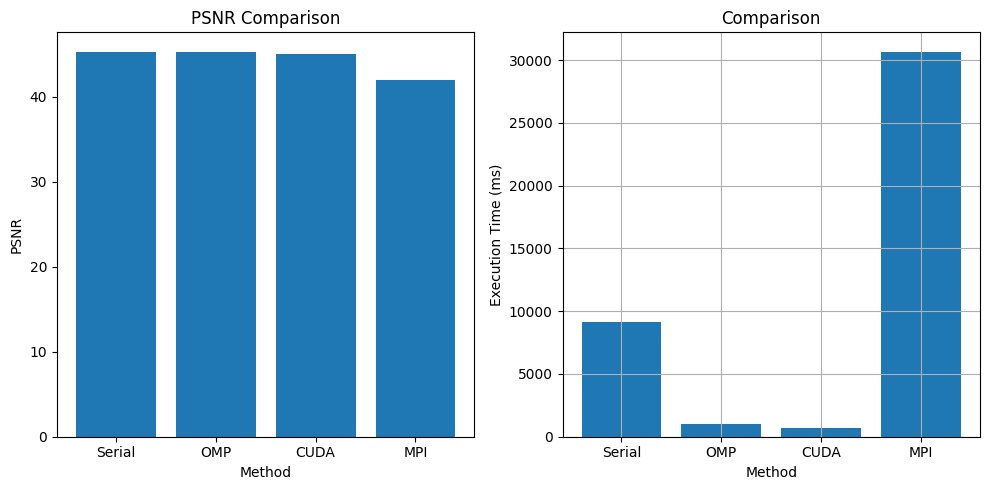

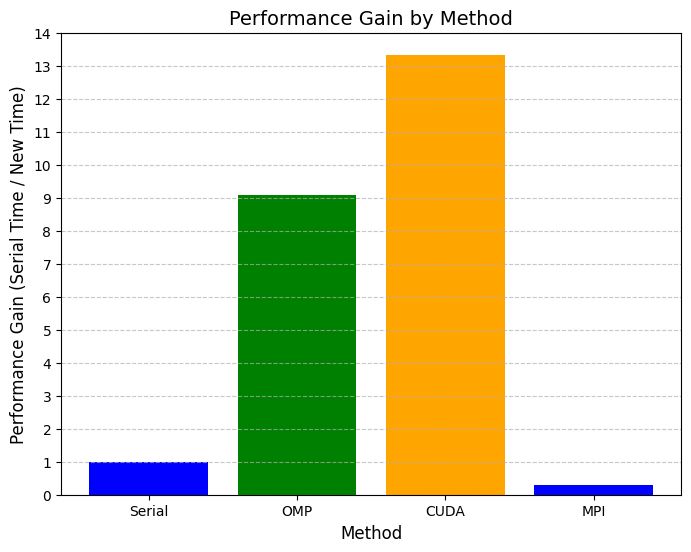

In [1]:
import subprocess
import matplotlib.pyplot as plt
import json
import numpy as np
from PIL import Image

def get_image_total_pixels(image_path):
  try:
    img = Image.open(image_path)
    width, height = img.size
    total_pixels = width * height
    return total_pixels
  except FileNotFoundError:
    print(f"Image not found at: {image_path}")
    return None
  except Exception as e:
    print(f"Error loading image: {e}")
    return None
    
def run_cpp_executable(executable_path, args):
 
  try:
    result = subprocess.run([executable_path] + args, 
                           stdout=subprocess.PIPE, 
                           stderr=subprocess.PIPE, 
                           check=True,
                           text=True)
    return result.stdout
  except subprocess.CalledProcessError as e:
    print(f"Error executing {executable_path}: {e}")
    return ""
#"apollo_medium.jpg"
original_images = ["aldrin.jpg","home.jpg"]
loop_number = "3"
executable_path = "./x64/Release/DWTSVD_Watermarking.exe"  
mpi_path = "./x64/Release/MPI_wm.exe"
#<original_image_path> <watermark_image_path> <watermark_width> <watermark_height> <type> <loop_number>
#For type: 0 = Serial, 1 = OMP, 2 = CUDA, 3 = MPI

def run_mpi(executable_path, num_iterations, ori, wm, size):
    num_processes = 6
    for i in range(num_iterations):
        print(f"Running MPI iteration {i+1}...")
        result = subprocess.run(
            ["mpiexec", "-n", str(num_processes), executable_path, ori, wm, size, size],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
        )

def plot_comparison(data):
    ordered_methods = ['seq', 'omp', 'mpi','cuda'] 
    methods = [method for method in ordered_methods if method in data] 
    embed_times = [data[method]['embed_time'] for method in methods]
    extract_times = [data[method]['extract_time'] for method in methods]
    psnrs = [data[method]['psnr'] for method in methods]

    x = np.arange(len(methods))

    methods = [d["method"] for d in data]
    psnrs = [d["psnr"] for d in data]
    times = [d["time"] for d in data]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot PSNR comparison
    axs[0].bar(methods, psnrs)
    axs[0].set_xlabel("Method")
    axs[0].set_ylabel("PSNR")
    axs[0].set_title("PSNR Comparison")

    # Plot execution time comparison
    axs[1].bar(methods, times)
    axs[1].set_xlabel("Method")
    axs[1].set_ylabel("Execution Time (ms)")
    axs[1].set_title("Execution Time Comparison")

    plt.title('Comparison')
    fig.tight_layout()
    plt.grid(True)
    plt.show()
    
    methods = [item["method"] for item in data]
    times = [item["time"] for item in data]
    
    # Serial time
    serial_time = next(item["time"] for item in data if item["method"] == "Serial")
    
    # Calculate performance gain
    performance_gains = [serial_time / time for time in times]
    
    # Create bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(methods, performance_gains, color=['blue', 'green', 'orange'])
    plt.title("Performance Gain by Method", fontsize=14)
    y_ticks = np.arange(0, int(max(performance_gains)) + 2, 1) 
    plt.yticks(y_ticks)
    plt.xlabel("Method", fontsize=12)
    plt.ylabel("Performance Gain (Serial Time / New Time)", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

image_paths = [
    "./resized_home.jpg", 
    "./serial_watermarked_image.tiff", 
    "./omp_watermarked_image.tiff", 
    "./cuda_watermarked_image.tiff",
    "./mpi_watermarked_image.tiff"
]

watermark_img = "mono.png"  #Path to Watermark image
watermark_size = "64"
is_display = "0" #use "1" if you want to display it


for i in original_images:
    open('mpi_time_result.json', 'w').close()
    open('time_result.json', 'w').close()
    
    args = [i, watermark_img, watermark_size, watermark_size, "0", loop_number, is_display] 
    output = run_cpp_executable(executable_path, args)
    print(output) 
    
    args = [i, watermark_img, watermark_size, watermark_size, "1", loop_number, is_display] 
    output = run_cpp_executable(executable_path, args)
    print(output) 
    
    args = [i, watermark_img, watermark_size, watermark_size, "2", loop_number, is_display] 
    output = run_cpp_executable(executable_path, args)
    print(output) 
    
    run_mpi(mpi_path, int(loop_number), i, watermark_img, watermark_size)

    with open('mpi_time_result.json', 'r') as f:
        mpi_data = json.load(f)
        total_psnr = sum(item["psnr"] for item in mpi_data)
        total_time = sum(item["time"] for item in mpi_data)
        average_psnr = total_psnr / len(mpi_data)
        average_time = total_time / len(mpi_data)
    
    with open('time_result.json', 'r') as f:
        data = json.load(f)

    mpi_data = {"method" : "MPI"}
    mpi_data["psnr"] = average_psnr
    mpi_data["time"] = average_time
    
    data.append(mpi_data)
    plot_comparison(data) 


Ensure the cell above is runned finish before executing the cell below. Cell below shows the extracted watermark after performing attacks onto the watermark image to display the robustness of the watermark. An image without watermark is passed into the program to extract watermark to show that without watermark, the extracted result is supposed to not ressamble any edges of the watermark but just blurred colors. 

In [ ]:
import subprocess

def run_cpp_executable(executable_path, args):
 
  try:
    result = subprocess.run([executable_path] + args, 
                           stdout=subprocess.PIPE, 
                           stderr=subprocess.PIPE, 
                           check=True,
                           text=True)
    return result.stdout
  except subprocess.CalledProcessError as e:
    return ""

original_image = "home.jpg"
watermark_image = "mono.png"
watermark_size = "64"
is_display = "1"
method = "serial"  #Method available: "serial", "omp" , "cuda"


args = ["attack", original_image, watermark_image, watermark_size, watermark_size, method, is_display] 
output = run_cpp_executable(executable_path, args)